In [1]:
import os
import json
from pathlib import Path
from collections import defaultdict
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import textwrap
import glob 
from openai import OpenAI
import time
from pydantic import BaseModel
from dotenv import load_dotenv

In [2]:
load_dotenv()
client = OpenAI(
    # This is the default and can be omitted
    api_key=os.getenv("OPENAI_API_KEY")
)

In [3]:
data_dir = Path('data')
# Create a nested defaultdict structure with three levels
traces_by_task = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

In [4]:
# List of valid error types we want to keep
valid_errors = {
    'enverror', 'keyerror', '\nruntimeerror', 
    'assertionerror', '\nvalueerror', 'syntaxerror', '\nimporterror',
    '\nattributeerror', 'outofmemoryerror', 'typeerror'
}

In [5]:
def is_actual_error(observation):
    # Ignore any error words that appear within backticks or double quotes
    # First remove text between backticks
    cleaned_text = re.sub(r'`[^`]*`', '', observation)
    # Then remove text between double quotes
    cleaned_text = re.sub(r'"[^"]*"', '', cleaned_text)
    
    # Check if the cleaned text contains any of our valid error types
    cleaned_text = cleaned_text.lower()
    return any(error in cleaned_text for error in valid_errors)

In [6]:
def get_last_agent_file(folder_path):
    # Find all agent files in the folder
    agent_files = glob.glob(os.path.join(folder_path, "agent_*_*.json"))
    
    if not agent_files:
        return None
    
    # Extract agent numbers and find the highest one
    max_agent_num = 0
    max_agent_file = None
    
    for file in agent_files:
        # Extract the number from filename using regex
        match = re.search(r"agent_(\d+)_\d+\.json", file)
        if match:
            agent_num = int(match.group(1))
            if agent_num > max_agent_num:
                max_agent_num = agent_num
                max_agent_file = file
    
    return max_agent_file

def extract_history_steps(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            
        # Extract history_steps without observation field
        history_steps = data.get('history_steps', [])
        
        # Remove observation field from each step
        # for step in history_steps:
        #     if 'observation' in step:
        #         del step['observation']

        #     if 'action' in step and isinstance(step['action'], dict):
        #         if 'Research Plan and Status' in step['action']:
        #             del step['action']['Research Plan and Status']
        #         if 'Fact Check' in step['action']:
        #             del step['action']['Fact Check']
                
        return history_steps
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def extract_task_name_and_id(folder_path):
    # Split the path into components
    parts = folder_path.split(os.sep)
    
    # Look for task name and run ID in the path
    task_name = None
    run_id = None
    
    for i, part in enumerate(parts):
        if i < len(parts) - 2 and parts[i+2].startswith('0'):  # Assuming run IDs start with numbers
            task_name = part
            run_id = parts[i+2]
            break
    
    return task_name, run_id

def process_all_folders(base_path):
    # Walk through directory structure
    for root, dirs, files in os.walk(base_path):
        # Check if this folder contains agent files
        
        agent_files = [f for f in files if f.startswith("agent_") and f.endswith(".json")]
        if agent_files:
            parts = root.split(os.sep)
            #print(f"{parts}")
            task_name = parts[1]
            model_name = parts[2]
            iteration = parts[3]
            error_observations = []
            last_agent = get_last_agent_file(root)
            if last_agent:
                history = extract_history_steps(last_agent)
                if history:
                    total_steps = len(history)
                    for step_num, step in enumerate(history, 1):
                        observation = step['observation']
                        if is_actual_error(observation):
                            next_steps = []
                            for i in range(1, total_steps - step_num + 1):
                                next_step_idx = step_num + i - 1  # -1 because step_num is 1-indexed but list is 0-indexed
                                if next_step_idx < total_steps:
                                    next_step = history[next_step_idx]
                                    next_step_info = {
                                        'step': step_num + i,
                                        'action': next_step['action']['Action'],
                                        'reflection': next_step['action']['Reflection'],
                                        'thought': next_step['action']['Thought'],
                                        'observation': next_step['observation']
                                    }
                                    next_steps.append(next_step_info)
                            error_info = {
                            'step': step_num,
                            'observation': observation,
                            'next_steps': next_steps
                            }
                            error_observations.append(error_info)
                    if error_observations:
                        traces_by_task[task_name][model_name][iteration] = {
                            'error_observations': error_observations,
                            'total_steps': total_steps,
                        }

In [7]:
base_directory = "data"
process_all_folders(base_directory)

In [8]:
# Convert defaultdict to regular dict for JSON serialization
traces_dict = json.loads(json.dumps(traces_by_task))

# Save to JSON file with nice formatting
with open('error_completion_with_next_steps.json', 'w') as f:
    json.dump(traces_dict, f, indent=2)

# Print summary
print("\nSummary of error analysis:")
total_errors = 0
total_next_steps = 0
for task_name, models in traces_dict.items():
    print(f"\nTask: {task_name}")
    task_errors = 0
    task_next_steps = 0
    
    for model_name, iterations in models.items():
        model_errors = sum(len(data['error_observations']) for data in iterations.values())
        
        # Count next steps
        model_next_steps = 0
        for iteration_data in iterations.values():
            for error_obs in iteration_data['error_observations']:
                model_next_steps += len(error_obs.get('next_steps', []))
        
        task_errors += model_errors
        task_next_steps += model_next_steps
        
        print(f"  Model: {model_name}")
        print(f"  Errors: {model_errors}")
        print(f"  Next steps captured: {model_next_steps}")
        print(f"  Avg next steps per error: {model_next_steps/model_errors:.2f}" if model_errors > 0 else "  Avg next steps per error: N/A")
    
    total_errors += task_errors
    total_next_steps += task_next_steps
    
    print(f"  Total task errors: {task_errors}")
    print(f"  Total next steps captured: {task_next_steps}")
    print(f"  Avg next steps per error: {task_next_steps/task_errors:.2f}" if task_errors > 0 else "  Avg next steps per error: N/A")

print(f"\nTotal errors across all tasks: {total_errors}")
print(f"Total next steps captured: {total_next_steps}")
print(f"Average next steps per error: {total_next_steps/total_errors:.2f}" if total_errors > 0 else "Average next steps per error: N/A")


Summary of error analysis:

Task: product-recommendation
  Model: gemini-exp-1206
  Errors: 50
  Next steps captured: 757
  Avg next steps per error: 15.14
  Total task errors: 50
  Total next steps captured: 757
  Avg next steps per error: 15.14

Task: weather_forcast
  Model: gemini-exp-1206
  Errors: 222
  Next steps captured: 8438
  Avg next steps per error: 38.01
  Total task errors: 222
  Total next steps captured: 8438
  Avg next steps per error: 38.01

Task: machine_unlearning
  Model: gemini-exp-1206
  Errors: 178
  Next steps captured: 3082
  Avg next steps per error: 17.31
  Total task errors: 178
  Total next steps captured: 3082
  Avg next steps per error: 17.31

Task: meta-learning
  Model: gemini-exp-1206
  Errors: 38
  Next steps captured: 826
  Avg next steps per error: 21.74
  Total task errors: 38
  Total next steps captured: 826
  Avg next steps per error: 21.74

Task: llm-merging
  Model: gemini-exp-1206
  Errors: 30
  Next steps captured: 484
  Avg next steps per

In [9]:
# Load the error data from the JSON file
with open('error_completion_with_next_steps.json', 'r') as f:
    error_data = json.load(f)

max_next_steps = 0
max_error_info = None

for task_name, models in error_data.items():
    for model_name, iterations in models.items():
        for iteration, iteration_data in iterations.items():
            for error_obs in iteration_data.get('error_observations', []):
                next_steps_count = len(error_obs.get('next_steps', []))
                if next_steps_count > max_next_steps:
                    max_next_steps = next_steps_count
                    max_error_info = {
                        'task': task_name,
                        'model': model_name,
                        'iteration': iteration,
                        'error_step': error_obs.get('step'),
                        'error_observation': error_obs.get('observation'),
                        'next_steps_count': next_steps_count,
                        'status': error_obs.get('Status')
                    }

print(f"Error with the most next steps ({max_next_steps} steps):")
print(f"Task: {max_error_info['task']}")
print(f"Model: {max_error_info['model']}")
print(f"Iteration: {max_error_info['iteration']}")
print(f"Error at step: {max_error_info['error_step']}")

Error with the most next steps (93 steps):
Task: weather_forcast
Model: gemini-exp-1206
Iteration: 0327052320_2068947
Error at step: 7


In [10]:
def process_and_analyze_files(error_completion_data):
    
    class Step(BaseModel):
        Status: int
        FixedAtStep: int = None

    for task_name, task_data in error_completion_data.items():
        for model_name, model_data in task_data.items():
            for iteration, iteration_data in model_data.items():
                # Process error observations
                for error_idx, error_obs in enumerate(iteration_data.get("error_observations", [])):
                    error_step = {
                        "step_number": error_obs.get("step"),
                        "content": error_obs.get("observation", ""),
                        "Next Steps": error_obs.get("next_steps", [])
                    }
                    prompt = f"""
                        Below is a detailed chain-of-thought from an agent after encountering an error message:
                        {error_step}

                        Based on the provided debugging steps, classify the agent response regarding the error as follows:

                        1 -> Fixed the error: The agent identified the issue and implemented a solution that resolved the error.
                        2 -> Tried to fix the error but didn't: The agent attempted to address the error but the fix was not successful.
                        3 -> Didn't even try to fix the error and just went off doing something else: The agent did not directly attempt to resolve the error but instead focused on other tasks unrelated to fixing it.
                        
                        If the error was fixed (status -> 1), also identify which step number was the error fixed at.
                        
                        Return a JSON with two fields:
                        - Status: The number (1, 2, or 3) corresponding to the classification
                        - FixedAtStep: The step number where the error was fixed (only if Status is 1, otherwise null)
                    """
                    completion = client.beta.chat.completions.parse(
                            model="gpt-4o-mini",
                            messages=[
                                {
                                    "role": "user",
                                    "content": prompt
                                }
                            ],
                            response_format=Step
                        )
                    
                    response_content = completion.choices[0].message.content
                        
                    response_json = json.loads(response_content)
                    #print(response_json['Status'])
                    traces_dict[task_name][model_name][iteration]['error_observations'][error_idx]['Status'] = response_json['Status']
                    if response_json['Status'] == 1 and response_json.get('FixedAtStep') is not None:
                        traces_dict[task_name][model_name][iteration]['error_observations'][error_idx]['FixedAtStep'] = response_json['FixedAtStep']


In [11]:
with open("error_completion_with_next_steps.json", "r") as f:
     data = json.load(f)

process_and_analyze_files(data)

with open('error_completion_with_next_steps.json', 'w') as f:
    json.dump(traces_dict, f, indent=2)

## MERGE EXISTING AND NEW TASKS

In [12]:
# import json

# # File paths
# main_file = 'error_completion_with_next_steps.json'
# new_tasks_file = 'error_completion_with_next_steps_new_tasks.json'
# output_file = main_file  # Will overwrite the main file with combined data

# # Load both files
# try:
#     with open(main_file, 'r') as f:
#         main_data = json.load(f)
#     print(f"Loaded main file with {len(main_data)} tasks")
# except FileNotFoundError:
#     main_data = {}
#     print(f"Main file {main_file} not found, starting with empty dictionary")

# try:
#     with open(new_tasks_file, 'r') as f:
#         new_data = json.load(f)
#     print(f"Loaded new tasks file with {len(new_data)} tasks")
# except FileNotFoundError:
#     new_data = {}
#     print(f"New tasks file {new_tasks_file} not found")
    
# if not new_data:
#     print("No new data to merge. Exiting.")
#     exit()

# # Function to count entries in the nested structure
# def count_entries(data):
#     task_count = 0
#     model_count = 0
#     error_count = 0
    
#     for task, task_data in data.items():
#         task_count += 1
#         for model, model_data in task_data.items():
#             model_count += 1
#             error_count += len(model_data)
    
#     return task_count, model_count, error_count

# # Count before merging
# main_tasks, main_models, main_errors = count_entries(main_data)
# new_tasks, new_models, new_errors = count_entries(new_data)

# print(f"Main file: {main_tasks} tasks, {main_models} models, {main_errors} errors")
# print(f"New file: {new_tasks} tasks, {new_models} models, {new_errors} errors")

# # Merge the data
# for task, task_data in new_data.items():
#     if task not in main_data:
#         # If task doesn't exist in main data, add it
#         main_data[task] = task_data
#         print(f"Added new task: {task}")
#     else:
#         # If task exists, merge models
#         for model, model_data in task_data.items():
#             if model not in main_data[task]:
#                 # If model doesn't exist for this task, add it
#                 main_data[task][model] = model_data
#                 print(f"Added new model {model} to task {task}")
#             else:
#                 # If model exists, merge error IDs
#                 for error_id, error_data in model_data.items():
#                     if error_id not in main_data[task][model]:
#                         # Add new error ID data
#                         main_data[task][model][error_id] = error_data
#                         print(f"Added new error ID {error_id} to task {task}, model {model}")
#                     else:
#                         # Error ID already exists - could update or skip
#                         # For safety, we'll just note it 
#                         print(f"Note: Error ID {error_id} already exists in task {task}, model {model}")

# # Save the merged data
# with open(output_file, 'w') as f:
#     json.dump(main_data, f, indent=2)

# # Count after merging
# merged_tasks, merged_models, merged_errors = count_entries(main_data)
# print(f"Merged file: {merged_tasks} tasks, {merged_models} models, {merged_errors} errors")
# print(f"Added: {merged_tasks - main_tasks} tasks, {merged_models - main_models} models, {merged_errors - main_errors} errors")
# print(f"Saved merged data to {output_file}")

Loaded main file with 6 tasks
Loaded new tasks file with 2 tasks
Main file: 6 tasks, 6 models, 45 errors
New file: 2 tasks, 2 models, 11 errors
Added new task: erasing_invisible_watermarks
Added new task: weather_forcast
Merged file: 8 tasks, 8 models, 56 errors
Added: 2 tasks, 2 models, 11 errors
Saved merged data to error_completion_with_next_steps.json


## PLOT

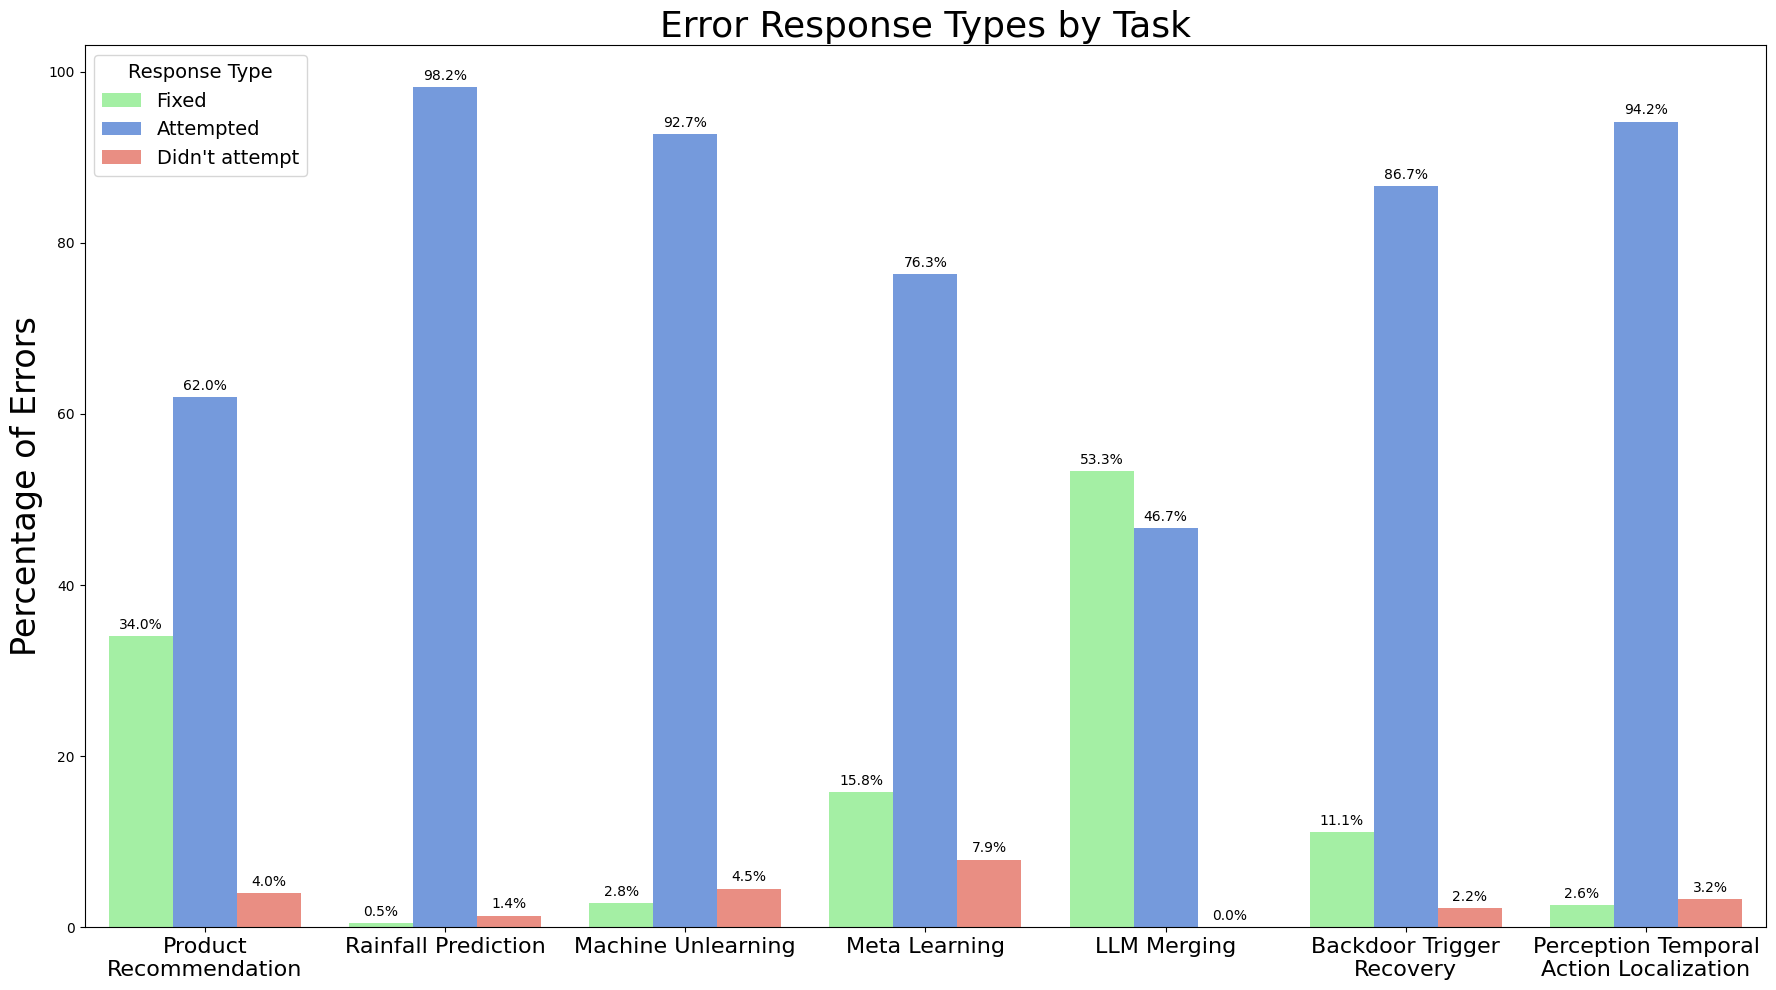


Summary Statistics:
Total tasks analyzed: 7
Average percentage of errors fixed: 17.2%
Average percentage of errors attempted but not fixed: 79.5%
Total errors across all tasks: 718.0


In [8]:
with open('error_completion_with_next_steps.json', 'r') as f:
    error_data = json.load(f)

# Initialize data structure to store counts for each task
task_error_stats = {}

# Define custom task names mapping
task_name_mapping = {
    "machine_unlearning": "Machine Unlearning",
    "product-recommendation": "Product Recommendation",
    "meta-learning": "Meta Learning",
    "llm-merging": "LLM Merging",
    "backdoor-trigger-recovery": "Backdoor Trigger Recovery",
    "perception_temporal_action_loc": "Perception Temporal Action Localization",
    "erasing_invisible_watermarks": "Erasing Invisible Watermarks",
    "weather_forcast": "Rainfall Prediction"
    # Add more mappings as needed for your tasks
}

# Define a color palette (from Stage_per_step.ipynb)
colors = {
    "Fixed": '#98FB98',           # Pale Green
    "Attempted": '#6495ED',     # Cornflower Blue
    "Didn't attempt": '#FA8072'  # Salmon
}

# Process the data
for task_name, models in error_data.items():
    # Initialize counters for this task
    fixed = 0
    attempted = 0
    didnt_attempt = 0
    total = 0
    
    # Aggregate across all models and iterations
    for model_name, iterations in models.items():
        for iteration, iteration_data in iterations.items():
            for error_obs in iteration_data.get('error_observations', []):
                status = error_obs.get('Status')
                if status == 1:
                    fixed += 1
                elif status == 2:
                    attempted += 1
                elif status == 3:
                    didnt_attempt += 1
                total += 1
    
    # Store the counts for this task
    if total > 0:
        # Use custom name if available, otherwise use original
        display_name = task_name_mapping.get(task_name, task_name)
        task_error_stats[display_name] = {
            'Fixed': (fixed / total) * 100,
            'Attempted': (attempted / total) * 100,
            'Didn\'t attempt': (didnt_attempt / total) * 100,
            'total_errors': total
        }

# Convert to DataFrame for easier plotting
df = pd.DataFrame(task_error_stats).T
df = df.reset_index()
df = df.rename(columns={'index': 'Task'})

# Melt the DataFrame for easier plotting with seaborn
plot_df = pd.melt(
    df, 
    id_vars=['Task', 'total_errors'], 
    value_vars=['Fixed', 'Attempted', 'Didn\'t attempt'],
    var_name='Response Type', 
    value_name='Percentage'
)

# Create the plot
plt.figure(figsize=(18, 10))  # Increased size to accommodate legend inside
ax = sns.barplot(x='Task', y='Percentage', hue='Response Type', data=plot_df, palette=colors)

# Wrap long task labels instead of rotating them
wrapped_labels = [textwrap.fill(label, width=20) for label in df['Task']]
ax.set_xticklabels(wrapped_labels, rotation=0, ha='center', fontsize=16)

# Add percentage labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

# Set plot title and labels
plt.title('Error Response Types by Task', fontsize=26)
plt.ylabel('Percentage of Errors', fontsize=24)
plt.xlabel('', fontsize=24)  # Empty because we have task names

# Position legend inside the plot in the upper left corner
# where it's less likely to overlap with bars
plt.legend(title='Response Type', loc='upper left', fontsize=14, title_fontsize=14)

# Adjust layout
plt.tight_layout()

os.makedirs("Error_completion", exist_ok=True)
plt.savefig('Error_completion/error_response_by_task.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total tasks analyzed: {len(task_error_stats)}")
print(f"Average percentage of errors fixed: {df['Fixed'].mean():.1f}%")
print(f"Average percentage of errors attempted but not fixed: {df['Attempted'].mean():.1f}%")
#print(f"Average percentage of errors not attempted: {df['Didn\\'t attempt'].mean():.1f}%")
print(f"Total errors across all tasks: {df['total_errors'].sum()}")